In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [437]:
# Load the dataset
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
df = pd.read_csv(url, skiprows=1)

In [439]:
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.19,-0.25,-.10,-.17,-.11,-.22,-.19,-.11,-.15,-.24,-.23,-.18,-.18,***,***,-.12,-.17,-.21
1,1881,-0.21,-0.15,.02,.04,.05,-.20,-.01,-.05,-.16,-.22,-.19,-.08,-.10,-.10,-.18,.04,-.08,-.19
2,1882,0.15,0.13,.04,-.17,-.15,-.23,-.17,-.08,-.15,-.24,-.17,-.37,-.12,-.09,.07,-.09,-.16,-.19
3,1883,-0.30,-0.37,-.13,-.19,-.18,-.08,-.08,-.15,-.23,-.12,-.25,-.12,-.18,-.20,-.35,-.17,-.10,-.20
4,1884,-0.14,-0.09,-.37,-.40,-.34,-.35,-.31,-.28,-.27,-.25,-.34,-.31,-.29,-.27,-.11,-.37,-.32,-.29


In [441]:
# Choose relevant columns
df = df[['Year', 'J-D']]

In [443]:
# Rename columns
df.rename(columns={'J-D':'Anomaly'}, inplace=True)

In [445]:
df

,Year,Anomaly
0,1880,-.18
1,1881,-.10
2,1882,-.12
3,1883,-.18
4,1884,-.29
...,...,...
141,2021,.85
142,2022,.89
143,2023,1.17
144,2024,1.28


In [447]:
# Drop year 2025
df.drop(index=145,axis=0,inplace=True)

In [449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     145 non-null    int64 
 1   Anomaly  145 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [451]:
# Convert data type for Anomaly
df['Anomaly'] = pd.to_numeric(df['Anomaly'])

In [453]:
# Check for Missing Values
df.isnull().sum()

Year       0
Anomaly    0
dtype: int64

In [455]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,145.0,1952.000000,42.001984,1880.00,1916.0,1952.00,1988.00,2024.00
Anomaly,145.0,0.073793,0.392740,-0.49,-0.2,-0.03,0.31,1.28


In [457]:
# Adjusting anomalies to pre-industrial baseline (1850–1900)
df['Anomaly'] = df['Anomaly'] + 0.3

In [459]:
df

,Year,Anomaly
0,1880,0.12
1,1881,0.20
2,1882,0.18
3,1883,0.12
4,1884,0.01
...,...,...
140,2020,1.31
141,2021,1.15
142,2022,1.19
143,2023,1.47


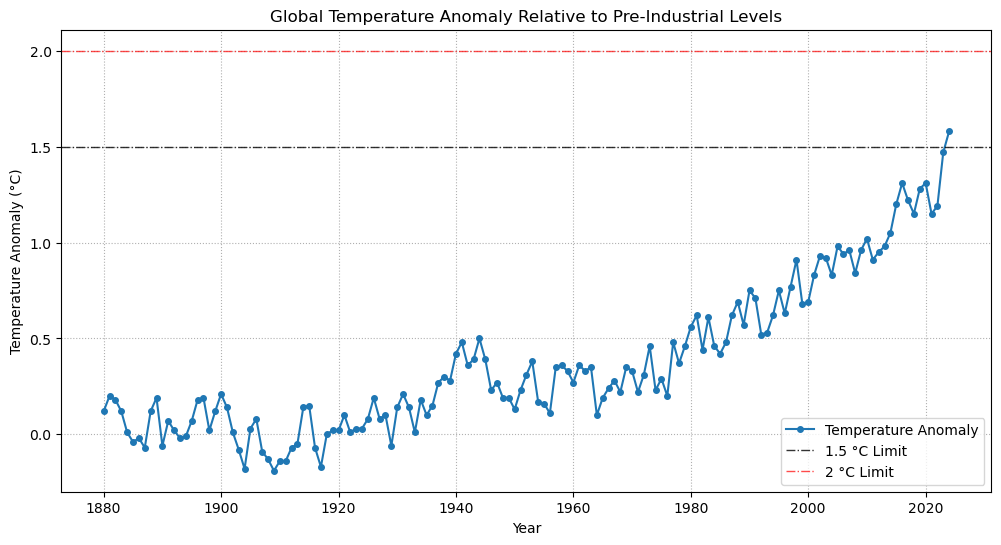

In [461]:
# Plot Temperature Anomalies Over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Anomaly'], marker='o', markersize=4, linestyle='-',label='Temperature Anomaly')
plt.axhline(1.5, color='black', linestyle='-.', label='1.5 °C Limit', linewidth=1, alpha=0.8)
plt.axhline(2, color='red', linestyle='-.', label='2 °C Limit', linewidth=1, alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Global Temperature Anomaly Relative to Pre-Industrial Levels')
plt.legend()
plt.grid(True, linestyle=':', linewidth=0.8)
plt.show()

In [463]:
# Identify Trends and Seasonality
decomposed = seasonal_decompose(df.set_index('Year')['Anomaly'], model='additive', period=10)

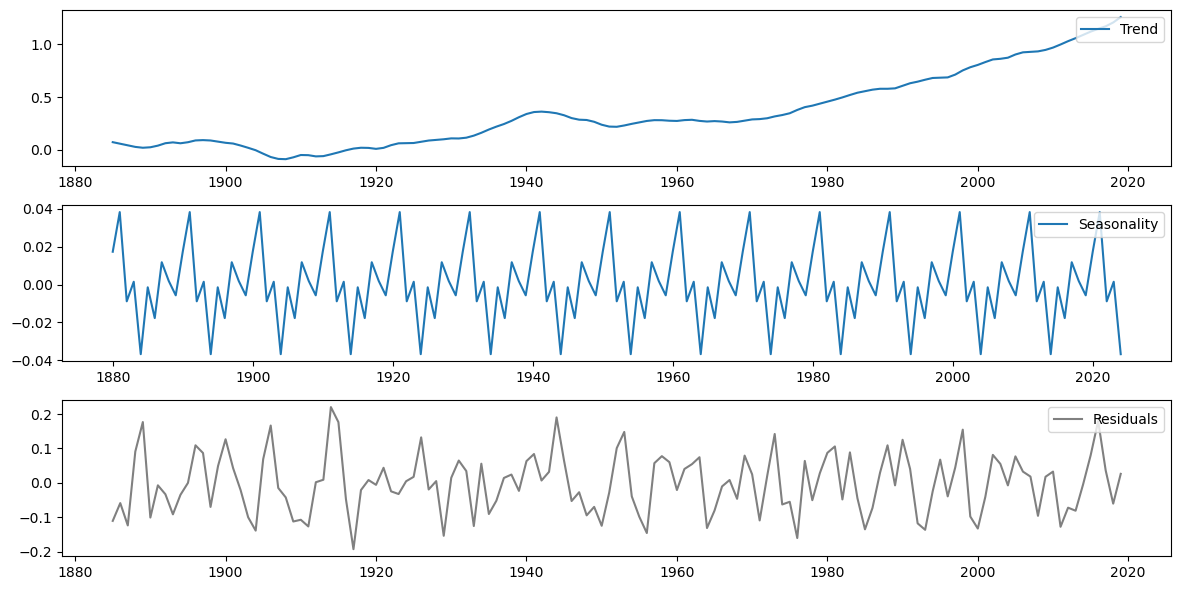

In [465]:
plt.figure(figsize=(12, 6))

plt.subplot(311)
plt.plot(decomposed.trend, label='Trend')
plt.legend(loc='upper right')

plt.subplot(312)
plt.plot(decomposed.seasonal, label='Seasonality')
plt.legend(loc='upper right')

plt.subplot(313)
plt.plot(decomposed.resid, label='Residuals', color='gray')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [467]:
# Forecasting Future Temperature Anomalies
# Using Auto-ARIMA to select best SARIMA model

import statsmodels.api as sm
from pmdarima import auto_arima 

In [469]:
stepwise_fit = auto_arima(df['Anomaly'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,   
                          stepwise = True)            
  
# Print summary 
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-103.721, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-127.918, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-103.973, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-149.933, Time=0.51 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-163.208, Time=1.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-174.259, Time=2.44 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-163.758, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  145
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 12)   Log Likelihood                  95.464
Date:                              Sat, 05 Apr 2025   AIC                           -176.927
Time:                                      17:29:11   BIC                           -156.748
Sample:                                           0   HQIC                          -168.727
                                              - 145                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3203      0.093     -3.427      0.001      -0.504      -0.137
ar.L2         -0.3715      0.096     -3.856      0.000      -0.560      -0.183
ar.L3         -0.2201      0.088     -2.514      0.012      -0.392      -0.048
ar.S.L12      -0.0710      0.141     -0.505      0.613      -0.347       0.205
ar.S.L24      -0.1224      0.123     -0.999      0.318      -0.363       0.118
ma.S.L12      -0.8128      0.187     -4.340      0.000      -1.180      -0.446
sigma2         0.0121      0.002      6.089      0.000       0.008       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.80   Prob(JB):                         0.47
Heteroskedasticity (H):               1.11   Skew:                            -0.03
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [471]:
# Fit SARIMAX model with Year as X (Exogenous)
model = sm.tsa.statespace.SARIMAX(df['Anomaly'], 
                                  exog=df[['Year']],  # Exogenous variable
                                  order=(3,1,0), 
                                  seasonal_order=(2,1,1,12), 
                                  enforce_stationarity=False, 
                                  enforce_invertibility=False)

result = model.fit()

# Print summary
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Anomaly   No. Observations:                  145
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 12)   Log Likelihood                  77.807
Date:                              Sat, 05 Apr 2025   AIC                           -139.614
Time:                                      17:31:18   BIC                           -118.382
Sample:                                           0   HQIC                          -131.010
                                              - 145                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Year       -3.168e-05   1329.282  -2.38e-08      1.000   -2605.346    2605.346
ar.L1         -0.39

In [473]:
# Forecast with exogenous variable (future years)
future_years = pd.DataFrame({'Year_Num': np.arange(df['Year'].iloc[-1] + 1, df['Year'].iloc[-1] + 21)})
forecast = result.get_forecast(steps=20, exog=future_years)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

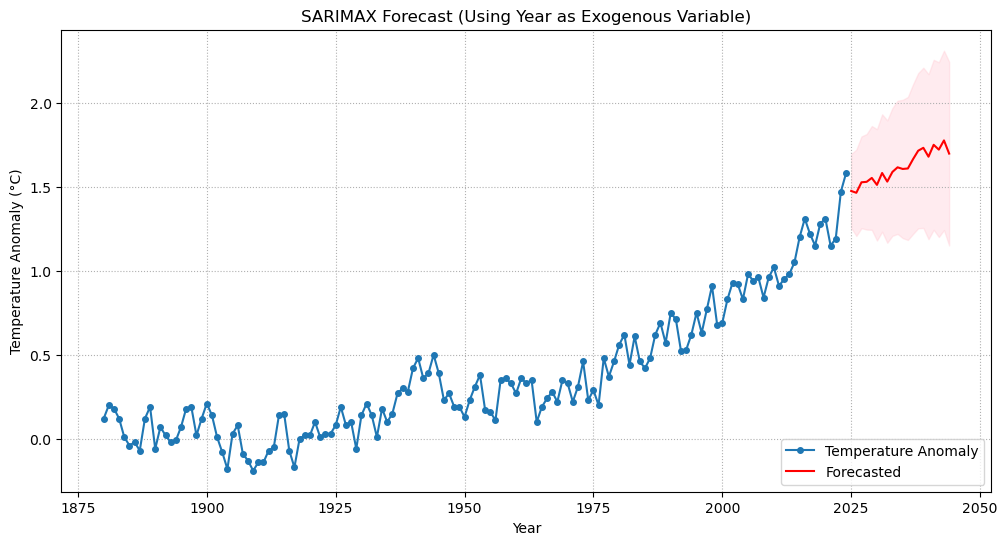

In [475]:
# Plot Actual vs Forecast

plt.figure(figsize=(12,6))
plt.plot(df['Year'], df['Anomaly'], marker='o', markersize=4, linestyle='-',label='Temperature Anomaly')
plt.plot(future_years['Year_Num'], forecast_mean, label="Forecasted", linestyle='-', color='red')
plt.fill_between(future_years['Year_Num'], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel("Year")
plt.ylabel('Temperature Anomaly (°C)')
plt.title("SARIMAX Forecast (Using Year as Exogenous Variable)")
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', linewidth=0.8)
plt.show()

In [477]:
# Forecast values
forecast_mean.reset_index(drop=True,inplace=True)
forecast_ci.reset_index(drop=True,inplace=True)

In [495]:
df_forecasted = pd.concat([future_years['Year_Num'], forecast_mean, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1]],axis=1)
df_forecasted

,Year_Num,predicted_mean,lower Anomaly,upper Anomaly
0,2025,1.474887,1.255589,1.694185
1,2026,1.463998,1.207277,1.720718
2,2027,1.526453,1.253480,1.799426
3,2028,1.529186,1.245088,1.813284
4,2029,1.552392,1.243554,1.861231
5,2030,1.510964,1.179544,1.842384
6,2031,1.581749,1.232548,1.930951
7,2032,1.530536,1.166487,1.894585
8,2033,1.588002,1.207874,1.968130
9,2034,1.615500,1.219212,2.011787


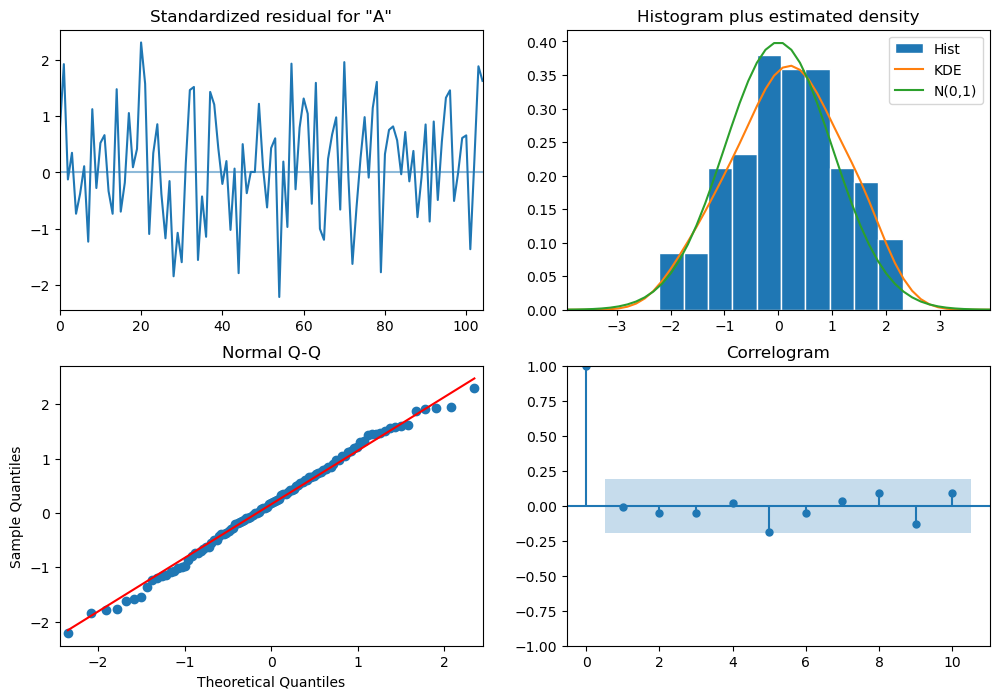

In [481]:
# Plot residuals
result.plot_diagnostics(figsize=(12, 8))
plt.show()

In [483]:
# Rolling Forecast Cross-Validation
# Lower average_mse means model fitted better

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Assuming df is the dataset with 'Year_Num' as exogenous and 'Temp_Anomaly' as target
data = df.copy()
n_splits = 15  # Number of cross-validation folds

# Define storage for errors
errors = []

# To ignore warnings
import warnings 
warnings.filterwarnings("ignore")

# Perform rolling forecast cross-validation
for i in range(n_splits, len(data) - 1):
    train = data.iloc[:i]  # Expanding training window
    test = data.iloc[i:i+1]  # Single-step ahead forecast
    
    # Define SARIMAX model
    model = sm.tsa.SARIMAX(train['Anomaly'], exog=train[['Year']],
                           order=(3,1,0), seasonal_order=(2,1,1,12),
                           enforce_stationarity=False, enforce_invertibility=False)
    
    # Fit the model
    result = model.fit(disp=False)

    # Forecast
    forecast = result.forecast(steps=1, exog=test[['Year']])  # One-step-ahead forecast

    # Compute error
    error = mean_squared_error(test['Anomaly'], forecast)
    errors.append(error)

# Compute average error across folds
average_mse = np.mean(errors)
print(f"Average MSE from Cross-Validation: {average_mse:.4f}")


Average MSE from Cross-Validation: 0.0260


In [ ]:
# Hypothesis Testing on global warming acceleration

In [ ]:
# Null Hypothesis (H₀): The rate of global warming has remained constant over time.
# Alternative Hypothesis (H₁): The rate of global warming has accelerated over time.

In [497]:
# Fit a Linear Model (Constant Rate of Warming)
from sklearn.linear_model import LinearRegression

X = df["Year"].values.reshape(-1, 1)
y = df["Anomaly"].values

In [499]:
# Fit Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X, y)

LinearRegression()

In [501]:
# Predict using Linear Model
y_pred_linear = linear_model.predict(X)

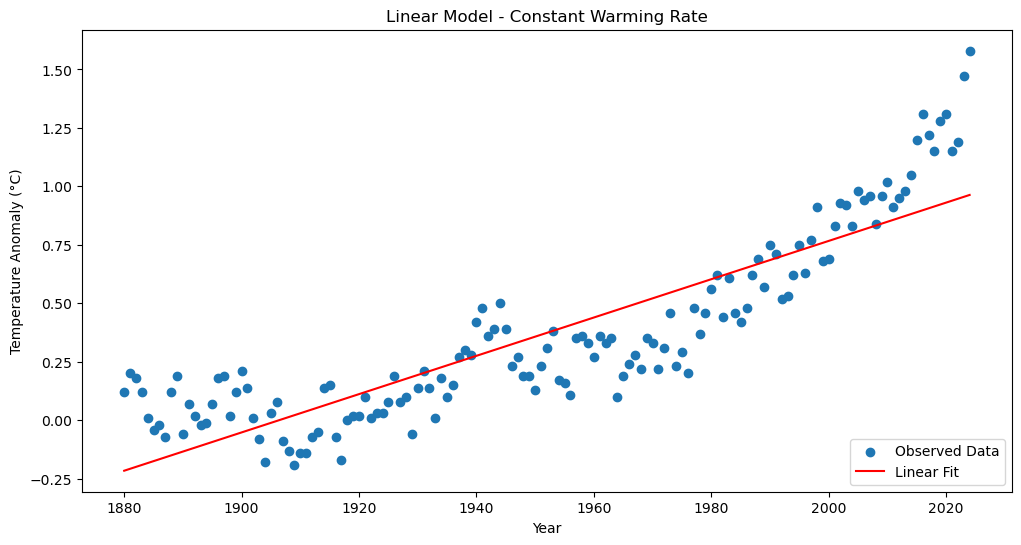

In [503]:
# Plot results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, label="Observed Data")
plt.plot(X, y_pred_linear, color='red', label="Linear Fit")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Linear Model - Constant Warming Rate")
plt.legend(loc="lower right")
plt.show()

In [505]:
# Fit a Quadratic Model (Acceleration Test)
#  using y=aX^2 +bX+c
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [507]:
# Create Polynomial Features (degree=2 for quadratic model)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

# Fit Quadratic Regression Model
quadratic_model = LinearRegression()
quadratic_model.fit(X_poly, y)

# Predict using Quadratic Model
y_pred_quadratic = quadratic_model.predict(X_poly)

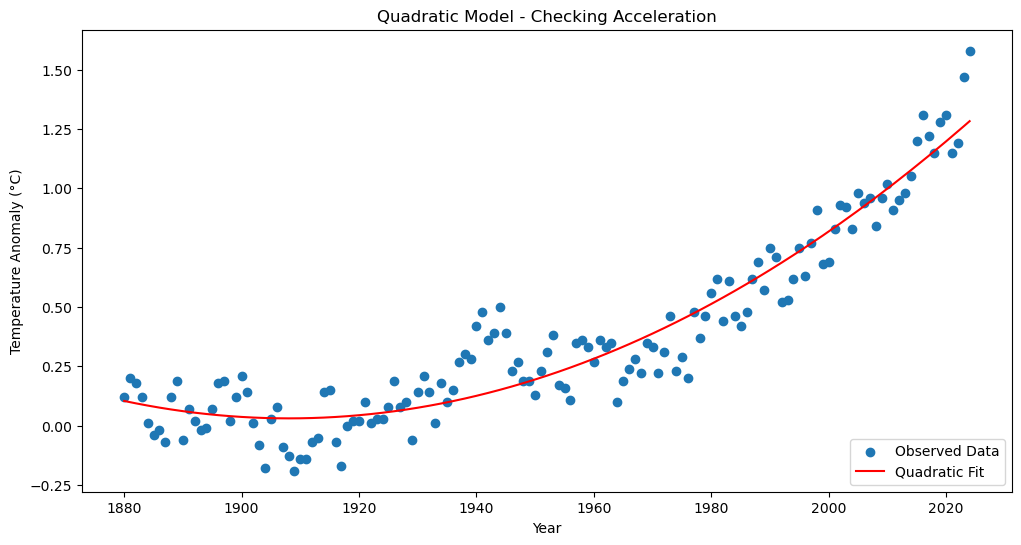

In [509]:
# Plot results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, label="Observed Data")
plt.plot(X, y_pred_quadratic, color='red', label="Quadratic Fit")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Quadratic Model - Checking Acceleration")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compare both models using R² (coefficient of determination) and Mean Squared Error (MSE)

In [511]:
from sklearn.metrics import mean_squared_error, r2_score

# Linear Model Performance
r2_linear = r2_score(y, y_pred_linear)
mse_linear = mean_squared_error(y, y_pred_linear)

# Quadratic Model Performance
r2_quadratic = r2_score(y, y_pred_quadratic)
mse_quadratic = mean_squared_error(y, y_pred_quadratic)

print(f"Linear Model - R²: {r2_linear:.4f}, MSE: {mse_linear:.4f}")
print(f"Quadratic Model - R²: {r2_quadratic:.4f}, MSE: {mse_quadratic:.4f}")

# Check which model fits better
if r2_quadratic > r2_linear:
    print("Quadratic model fits better → Evidence of acceleration in global warming.")
else:
    print("Linear model fits better → No strong evidence of acceleration.")

Linear Model - R²: 0.7669, MSE: 0.0357
Quadratic Model - R²: 0.9061, MSE: 0.0144
Quadratic model fits better → Evidence of acceleration in global warming.


In [513]:
# Using Change Point Detection (CPD) to identify significant shifts in temperature
import ruptures as rpt
from scipy.stats import linregress
import pymannkendall as mk

In [515]:
# Apply Change Point Detection using Pelt Algorithm
model = "rbf"  # "rbf" works well for climate trends, detects shifts in variance
algo = rpt.Pelt(model=model).fit(y)
change_points = algo.predict(pen=10)  # Adjust penalty to control sensitivity

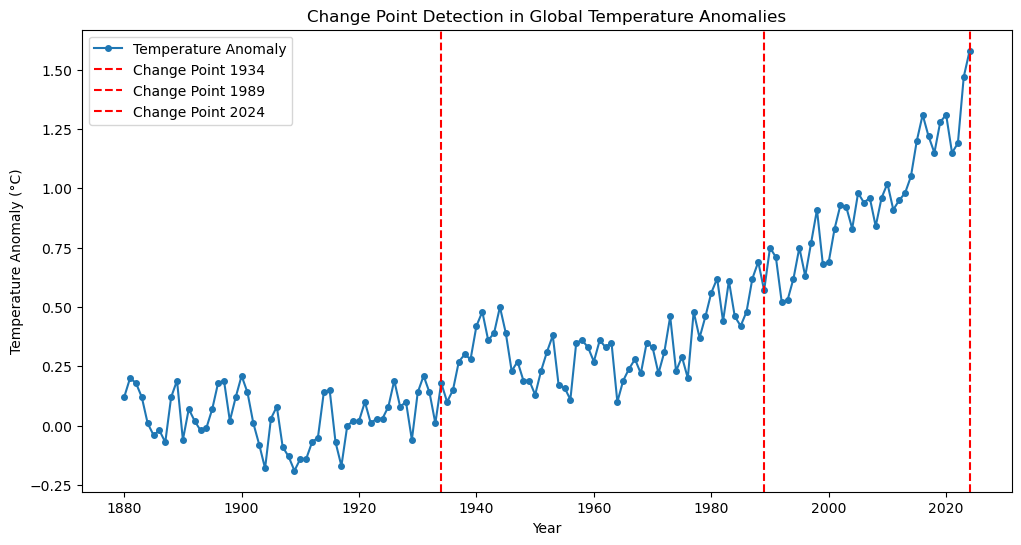

In [517]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Anomaly'], marker='o', markersize=4, linestyle='-',label='Temperature Anomaly')
for cp in change_points:
    plt.axvline(df['Year'][cp-1], color="red", linestyle="--", label=f"Change Point {df['Year'][cp-1]}")

plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Change Point Detection in Global Temperature Anomalies")
plt.legend()
plt.show()

In [519]:
# Define change points
change_points = [1934, 1989, 2024]

In [521]:
# Create segments
segments = []
start = df['Year'].min()
for cp in change_points:
    segments.append(df[(df['Year'] >= start) & (df['Year'] < cp)])
    start = cp
segments.append(df[df['Year'] >= start])

Before 1934: Mann-Kendall Trend - no trend, p-value: 0.9821158184459773
1934-1989: Mann-Kendall Trend - increasing, p-value: 0.00047373029599029337
1989-2024: Mann-Kendall Trend - increasing, p-value: 5.696709770575126e-11


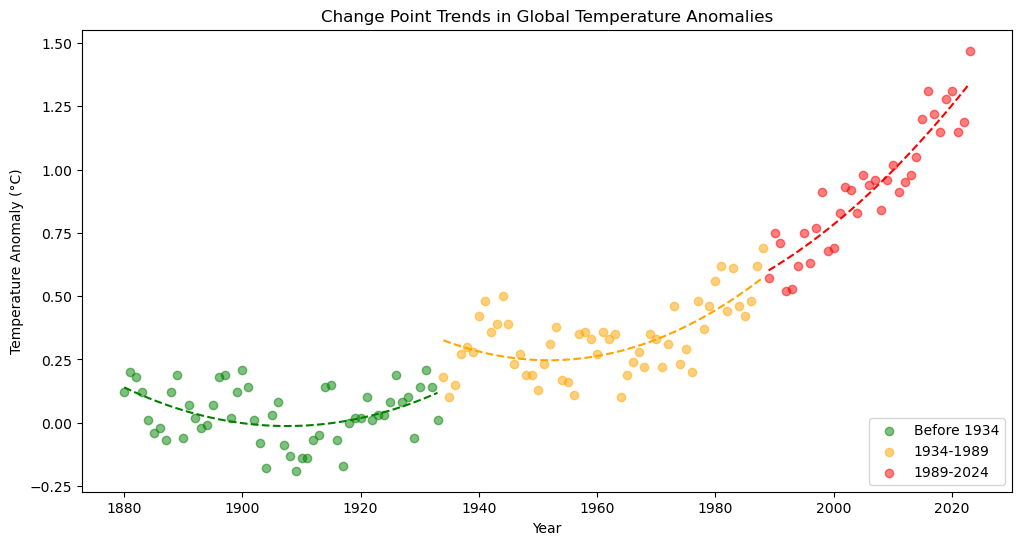

In [523]:
# Plot segmented trends
plt.figure(figsize=(12, 6))
colors = ['green', 'orange', 'red']
labels = ['Before 1934', '1934-1989', '1989-2024']

for i, segment in enumerate(segments):
    if len(segment) < 2:
        continue 
    
    x = segment['Year'].values.reshape(-1, 1)
    y = segment['Anomaly'].values
    
    # Linear Trend
    slope, intercept, r_value, p_value, std_err = linregress(x.flatten(), y)
    trend_label = f"{labels[i]}"
    
    # Quadratic Trend
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(x)
    model = LinearRegression().fit(X_poly, y)
    
    # Plot Linear Trend
    plt.scatter(x, y, color=colors[i], alpha=0.5, label=trend_label)
    plt.plot(x, model.predict(X_poly), color=colors[i], linestyle='dashed')
    
    # Mann-Kendall Test
    mk_result = mk.original_test(y)
    print(f"{labels[i]}: Mann-Kendall Trend - {mk_result.trend}, p-value: {mk_result.p}")

plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Change Point Trends in Global Temperature Anomalies")
plt.legend(loc='lower right')
plt.show()